In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Importing the Libraries.
import keras
import os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
#import keras.backend as K
import tensorflow.keras.backend as K
import tensorflow.compat.v1 as tf
from os import listdir
from os.path import isfile, join
import numpy as np
import sys
import os
import shutil
import pandas as pd
from PIL import Image
import cv2
import keras
import glob
from PIL import Image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPool2D
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.models import load_model
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from PIL import ImageFile

tf.enable_eager_execution()

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Data Augmentation.
DataGenerator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1./255, brightness_range=[0.2,0.7])

In [ ]:
TestGenerator = ImageDataGenerator(rescale=1./255)

In [ ]:
Grey_TrainingData = DataGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Train/', target_size=(224,224), batch_size=8, color_mode='grayscale')

Found 2015 images belonging to 112 classes.


In [ ]:
Grey_ValidData = TestGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Valid/', target_size=(224,224),batch_size=8, color_mode='grayscale')

Found 112 images belonging to 112 classes.


In [ ]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [ ]:
from keras.applications import ResNet50

In [ ]:
# Convoluted Base Model.
conv_base = ResNet50(weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
# Make last block of the conv_base trainable:

for layer in conv_base.layers[:165]:
   layer.trainable = False
for layer in conv_base.layers[165:]:
   layer.trainable = True
for layer in conv_base.layers:
  if isinstance(layer, BatchNormalization):
    layer.trainable = True

In [ ]:
model = Sequential()

In [ ]:
from keras.layers import Input 

In [ ]:
input_tensor = Input(shape=(224,224,1))
x = Conv2D(3,(3,3), padding='same')(input_tensor)
out = conv_base(x)

In [ ]:
models = Model(inputs = input_tensor, outputs = out)

In [ ]:
model.add(models)

In [ ]:
# Adding layers.
model.add(Flatten())
model.add(Dense(2048, activation='relu', kernel_regularizer= regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(112, activation='softmax'))

In [ ]:
from keras.optimizers import SGD

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.001),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("/content/drive/My Drive/1-piece/GreyScale_SGDResnet50.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 50,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 50,
                              verbose = 1,
                              min_delta = 0.00001)

callBacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
hist = model.fit_generator(steps_per_epoch=252,generator= Grey_TrainingData, validation_data= Grey_ValidData, validation_steps=14,epochs=150,callbacks=callBacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/150
252/252 [==============================] - ETA: 0s - loss: 9.2228 - accuracy: 0.0734
Epoch 00001: val_loss improved from inf to 21.93598, saving model to /content/drive/My Drive/1-piece/GreyScale_SGDResnet50.h5
252/252 [==============================] - 1168s 5s/step - loss: 9.2228 - accuracy: 0.0734 - val_loss: 21.9360 - val_accuracy: 0.0089
Epoch 2/150
252/252 [==============================] - ETA: 0s - loss: 7.2721 - accuracy: 0.2452
Epoch 00002: val_loss did not improve from 21.93598
252/252 [==============================] - 102s 406ms/step - loss: 7.2721 - accuracy: 0.2452 - val_loss: 76.3916 - val_accuracy: 0.0089
Epoch 3/150
252/252 [==============================] - ETA: 0s - loss: 6.4721 - accuracy: 0.3931
Epoch 00003: val_loss did not improve from 21.93598
252/252 [==============================] - 86s 343ms/step - loss: 6.4721 - accuracy: 0.3931 - val_loss: 64.8917 - val_accuracy: 0.008

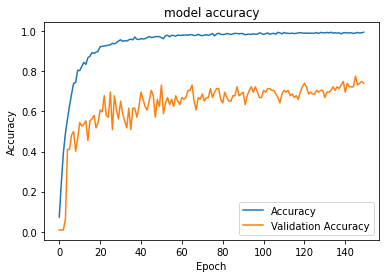

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

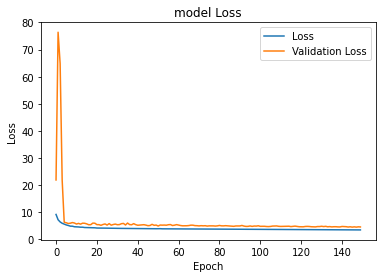

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [ ]:
GreyTestData = TestGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Test/', target_size=(224,224), batch_size = 8, shuffle = False, color_mode='grayscale')

Found 112 images belonging to 112 classes.


In [ ]:
Grey_predict = model.predict(GreyTestData)

In [ ]:
Grey_predict_classes = np.argmax(Grey_predict, axis=1)

In [ ]:
Grey_predict_classes

array([ 33,   1, 105,  11,   4,  36,   6,   7,   8,   9,   9,  11,  36,
        13,  14,  34,  54,  17,   9,   6,  32,  21,  22,  23,  24,  25,
       104,  27,   2,  96,  24,  11,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44, 104,  46,  47,  48,  49,  50,  51,
        52,  65,  54,  55,  56,  57,  68,  66,  60,  61,  62,  57,  64,
        65,  66,  67,  52,  69,  28,  71,  26,  73,  72,  75,  51,  43,
        54,  79,  80,  74,  82,  83,  84,  85,  86,  87,  88,  58,  66,
        92,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,  66, 103,
       104, 105,  66, 106, 108, 109, 110, 111])

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [ ]:
Grey_accuracy = accuracy_score(GreyTestData.classes, Grey_predict_classes)
print("Grey Accuracy: ", Grey_accuracy)

Grey Accuracy:  0.6875


In [ ]:
Grey_precision = precision_score(GreyTestData.classes, Grey_predict_classes,average="weighted")
print("Grey Precision: ", Grey_precision)

Grey Precision:  0.5925595238095237


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Grey_recall = recall_score(GreyTestData.classes, Grey_predict_classes, average="weighted")
print("Grey Recall:", Grey_recall)

Grey Recall: 0.6875


In [ ]:
Grey_f1_score = f1_score(GreyTestData.classes, Grey_predict_classes, average="weighted")
print("F1 score for Grey: ", Grey_f1_score)

F1 score for Grey:  0.6205357142857143


In [ ]:
Colour_TrainingData =  DataGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Train/', target_size=(224,224), batch_size=8)

Found 2015 images belonging to 112 classes.


In [ ]:
Colour_ValidData =  DataGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Valid/', target_size=(224,224), batch_size=8)

Found 112 images belonging to 112 classes.


In [ ]:
# Convoluted Base Model.
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [ ]:
# Make last block of the conv_base trainable:

for layer in conv_base.layers[:165]:
   layer.trainable = False
for layer in conv_base.layers[165:]:
   layer.trainable = True
for layer in conv_base.layers:
  if isinstance(layer, BatchNormalization):
    layer.trainable = True


In [ ]:
model = Sequential()

In [ ]:
model.add(conv_base)

In [ ]:
# Adding layers.
model.add(Flatten())
model.add(Dense(2048, activation='relu', kernel_regularizer= regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(112, activation='softmax'))

In [ ]:
from keras.optimizers import SGD

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.001),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("/content/drive/My Drive/1-piece/Colour_SGDResnet50.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 50,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 50,
                              verbose = 1,
                              min_delta = 0.00001)

callBacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
hist = model.fit_generator(steps_per_epoch=252,generator= Colour_TrainingData, validation_data= Colour_ValidData, validation_steps=14,epochs=150,callbacks=callBacks)

Epoch 1/150
252/252 [==============================] - ETA: 0s - loss: 8.8549 - accuracy: 0.1221
Epoch 00001: val_loss improved from inf to 27.47686, saving model to /content/drive/My Drive/1-piece/Colour_SGDResnet50.h5
252/252 [==============================] - 93s 367ms/step - loss: 8.8549 - accuracy: 0.1221 - val_loss: 27.4769 - val_accuracy: 0.0089
Epoch 2/150
252/252 [==============================] - ETA: 0s - loss: 6.5366 - accuracy: 0.4089
Epoch 00002: val_loss did not improve from 27.47686
252/252 [==============================] - 87s 346ms/step - loss: 6.5366 - accuracy: 0.4089 - val_loss: 49.7069 - val_accuracy: 0.0089
Epoch 3/150
252/252 [==============================] - ETA: 0s - loss: 5.6790 - accuracy: 0.5742
Epoch 00003: val_loss did not improve from 27.47686
252/252 [==============================] - 85s 338ms/step - loss: 5.6790 - accuracy: 0.5742 - val_loss: 59.4754 - val_accuracy: 0.0179
Epoch 4/150
252/252 [==============================] - ETA: 0s - loss: 5.2679

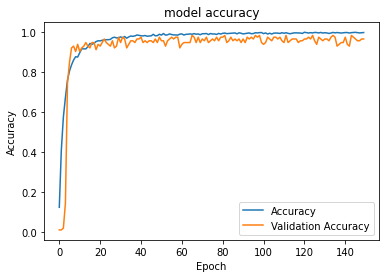

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

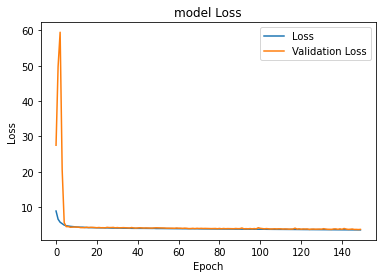

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [ ]:
Colour_TestData = TestGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Test/', target_size=(224,224), batch_size = 8, shuffle = False)

Found 112 images belonging to 112 classes.


In [ ]:
Colour_predict = model.predict(Colour_TestData)

In [ ]:
Colour_predict_classes = np.argmax(Colour_predict, axis=1)

In [ ]:
Colour_predict_classes

array([  0,  27,  27,   8,   4,   5,   6,   7,   8,  27,  27,  11,  12,
        13,  14,  34,  98,  17,  18,  18,  20,  21,  22,  23,  24,  25,
        27,  27,  37,  57,  30,  31,  32,  33,  54,  35,  36,  37,  38,
        39,  40,  41,  42,  43, 100,  51,  46,  47,  48,  49,  50,  51,
        52,  65,  54,  55,  56,  57,  58,  63,  60,  61,  62,  87,  64,
        67,  66,  67,  68,  69,  70,  71,  72,  73,  74,  89,  51,  77,
        26,  79,  62,  63,  82,  83,  84,  85,  86,  87,  58,  89,  90,
        91,  92,  48,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111])

In [ ]:
Colour_accuracy = accuracy_score(Colour_TestData.classes, Colour_predict_classes)
print("Colour Accuracy: ", Colour_accuracy)

Colour Accuracy:  0.7767857142857143


In [ ]:
Colour_precision = precision_score(Colour_TestData.classes, Colour_predict_classes,average="weighted")
print("Colour Precision: ", Colour_precision)

Colour Precision:  0.7053571428571429


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Colour_recall = recall_score(Colour_TestData.classes, Colour_predict_classes, average="weighted")
print("Colour Recall:", Colour_recall)

Colour Recall: 0.7767857142857143


In [ ]:
Colour_f1_score = f1_score(Colour_TestData.classes, Colour_predict_classes, average="weighted")
print("F1 score for colour: ", Colour_f1_score)

F1 score for colour:  0.7272534013605442


In [ ]:
Final = 0.6* Colour_predict + 0.4* Grey_predict

In [ ]:
Final_Predict_classes = np.argmax(Final, axis=1)

In [ ]:
Final_accuracy = accuracy_score(Colour_TestData.classes, Final_Predict_classes)
print("Colour Accuracy: ", Final_accuracy)

Colour Accuracy:  0.7946428571428571


In [ ]:
Final_precision = precision_score(Colour_TestData.classes, Final_Predict_classes,average="weighted")
print("Colour Precision: ", Final_precision)

Colour Precision:  0.7249999999999999


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Final_recall = recall_score(Colour_TestData.classes, Final_Predict_classes, average="weighted")
print("Colour Recall:", Final_recall)

Colour Recall: 0.7946428571428571


In [ ]:
Final_f1_score = f1_score(Colour_TestData.classes, Final_Predict_classes, average="weighted")
print("F1 score for colour: ", Final_f1_score)

F1 score for colour:  0.7455357142857143


In [ ]:
Second_final = 0.5* Colour_predict + 0.5* Grey_predict

In [ ]:
Second_Final_Predict_classes = np.argmax(Second_final, axis=1)

In [ ]:
Mean_Final_accuracy = accuracy_score(Colour_TestData.classes, Second_Final_Predict_classes)
print("Colour Accuracy: ", Mean_Final_accuracy)

Colour Accuracy:  0.8035714285714286


In [ ]:
Mean_Precision = precision_score(Colour_TestData.classes, Second_Final_Predict_classes, average="weighted")
Mean_Precision

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.7351190476190476

In [ ]:
Mean_Recall = recall_score(Colour_TestData.classes, Second_Final_Predict_classes, average="weighted")
Mean_Recall

0.8035714285714286

In [ ]:
Mean_F1Score = f1_score(Colour_TestData.classes, Second_Final_Predict_classes, average="weighted")
Mean_F1Score

0.7556547619047619